In [20]:
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import Math, display
from matplotlib.axes import Axes
from scipy import constants as const
from scipy.integrate import quad
from scipy.optimize import root_scalar
from tqdm import tqdm

import fewfermions.analysis.units as si
from fewfermions.simulate.traps.twod.trap import PancakeTrap
from fewfermions.style import FIGS_PATH, setup

colors, colors_alpha = setup()
pass

# Determining good parameters for Dysprosium

power

gradient

w_0


In [21]:
initial_power = 291.5 * si.uW
trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0.6 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer= 1.838 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
)
axial_width = trap.get_tweezer_rayleigh()

x, y, z = trap.x, trap.y, trap.z

In [22]:
aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))

<IPython.core.display.Math object>

#### Same parameters as for Li6 gives no trapped atoms -> reduce magnetic gradient from 15 G/cm to 0.6 G/cm:

In [8]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

#spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
#powers = trap[trap.power_tweezer] * spill_power_factor
powers = np.linspace(151.5,204,n_spill_steps)*si.uW
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)
#array to store mean lifetime at specific power
mean_lifetime = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 30
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))
    mean_lifetime[i] = np.mean(1/tunneling_rate[~np.isnan(tunneling_rate)])

  0%|          | 0/100 [00:00<?, ?it/s]

<lambdifygenerated-402>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.14251275879322e-39*z/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2) - 5.52545520465114e-25
<lambdifygenerated-403>:2: RuntimeWarning: overflow encountered in scalar power
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
<lambdifygenerated-403>:2: RuntimeWarning: invalid value encountered in scalar divide
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
c:\Users\peter\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\peter\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(re

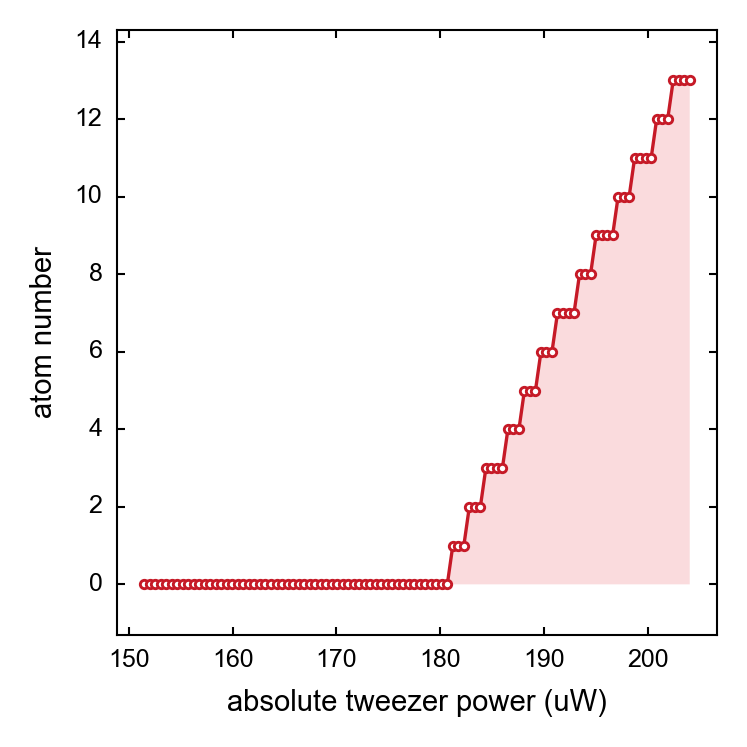

In [9]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("absolute tweezer power (uW)")
ax.set_ylabel("atom number")
ax.plot(powers*1e6, atom_number, marker=".")
ax.fill_between(powers*1e6, atom_number, fc=colors_alpha["red"], alpha=0.5)
#fig.savefig(FIGS_PATH / "twodtrap" / "1D Stufenplot.pdf")

In [19]:
mean_lifetime

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  

## Compare different "n_levels" (should not make a difference)

### 10

In [23]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

#spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
#powers = trap[trap.power_tweezer] * spill_power_factor
powers = np.linspace(151.5,204,n_spill_steps)*si.uW
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)
#array to store mean lifetime at specific power
mean_lifetime = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 10
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))
    mean_lifetime[i] = 1/np.mean(tunneling_rate[~np.isnan(tunneling_rate)])

  0%|          | 0/100 [00:00<?, ?it/s]<lambdifygenerated-2402>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.14251275879322e-39*z/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2) - 5.52545520465114e-25
<lambdifygenerated-2403>:2: RuntimeWarning: overflow encountered in scalar power
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
<lambdifygenerated-2403>:2: RuntimeWarning: invalid value encountered in scalar divide
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
c:\Users\peter\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_root_scalar.py:326: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=fprime2, **kwargs)
c:\Users\peter\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: Runtim

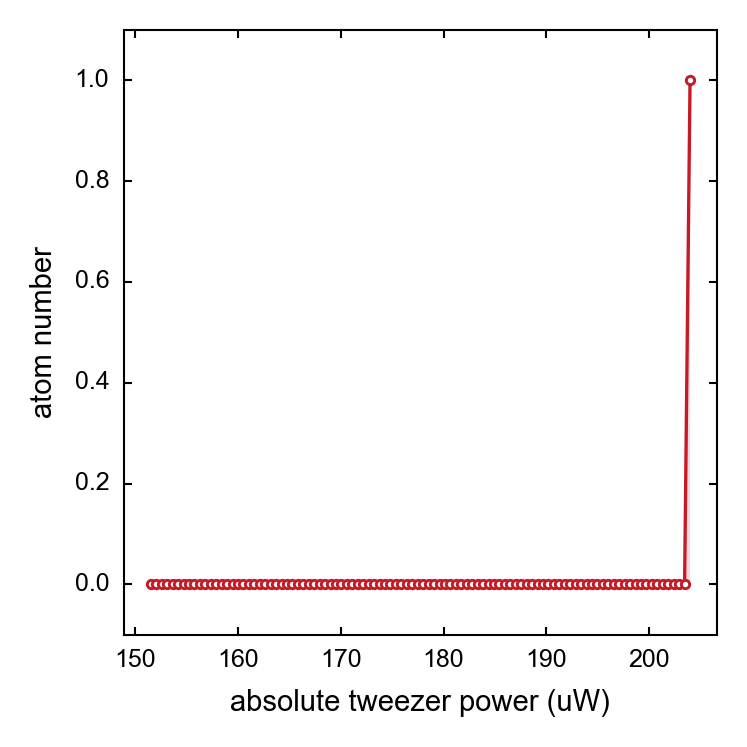

In [24]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("absolute tweezer power (uW)")
ax.set_ylabel("atom number")
ax.plot(powers*1e6, atom_number, marker=".")
ax.fill_between(powers*1e6, atom_number, fc=colors_alpha["red"], alpha=0.5)
#fig.savefig(FIGS_PATH / "twodtrap" / "1D Stufenplot.pdf")

### 40

In [25]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

#spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
#powers = trap[trap.power_tweezer] * spill_power_factor
powers = np.linspace(151.5,204,n_spill_steps)*si.uW
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)
#array to store mean lifetime at specific power
mean_lifetime = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 40
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))
    mean_lifetime[i] = 1/np.mean(tunneling_rate[~np.isnan(tunneling_rate)])

  0%|          | 0/100 [00:00<?, ?it/s]

<lambdifygenerated-2802>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.14251275879322e-39*z/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2) - 5.52545520465114e-25
<lambdifygenerated-2803>:2: RuntimeWarning: overflow encountered in scalar power
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
<lambdifygenerated-2803>:2: RuntimeWarning: invalid value encountered in scalar divide
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
  1%|          | 1/100 [00:00<00:25,  3.92it/s]<lambdifygenerated-2806>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.15701300347347e-39*z/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2) - 5.52545520465114e-25
<lambdifygenerated-2807>:2: RuntimeWarning: overflow encountered in scalar power
  return -1.66280520138939e-38*z

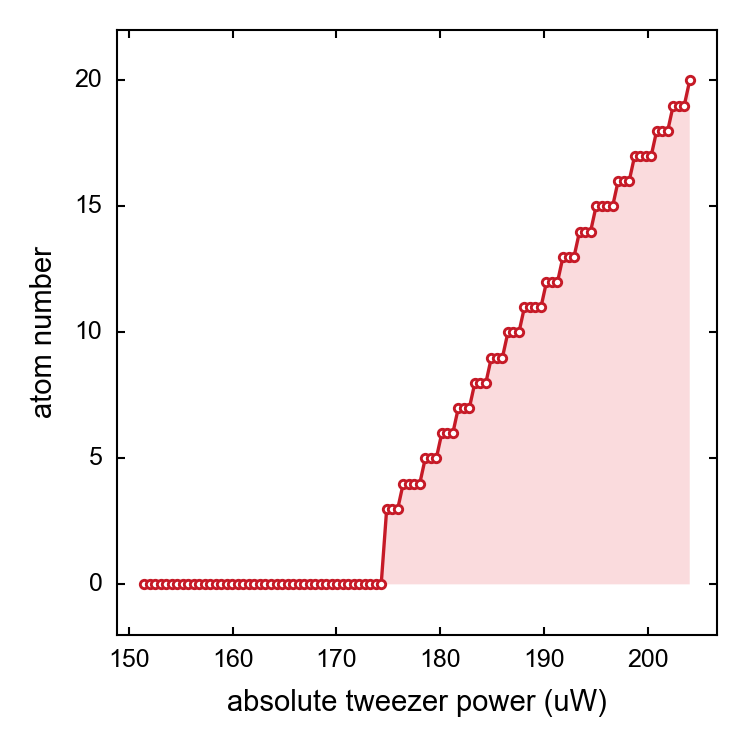

In [26]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("absolute tweezer power (uW)")
ax.set_ylabel("atom number")
ax.plot(powers*1e6, atom_number, marker=".")
ax.fill_between(powers*1e6, atom_number, fc=colors_alpha["red"], alpha=0.5)
#fig.savefig(FIGS_PATH / "twodtrap" / "1D Stufenplot.pdf")

### 60

In [ ]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

#spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
#powers = trap[trap.power_tweezer] * spill_power_factor
powers = np.linspace(151.5,204,n_spill_steps)*si.uW
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)
#array to store mean lifetime at specific power
mean_lifetime = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 60
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))
    mean_lifetime[i] = 1/np.mean(tunneling_rate[~np.isnan(tunneling_rate)])

  0%|          | 0/100 [00:00<?, ?it/s]<lambdifygenerated-3202>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.14251275879322e-39*z/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2) - 5.52545520465114e-25
<lambdifygenerated-3203>:2: RuntimeWarning: overflow encountered in scalar power
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
<lambdifygenerated-3203>:2: RuntimeWarning: invalid value encountered in scalar divide
  return -1.65700510351729e-38*z**2/(pi**5*(z**2/pi**2 + 4.03235503827802e-11)**3) + 4.14251275879322e-39/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2)
  1%|          | 1/100 [00:00<00:32,  3.06it/s]<lambdifygenerated-3206>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.15701300347347e-39*z/(pi**3*(z**2/pi**2 + 4.03235503827802e-11)**2) - 5.52545520465114e-25
<lambdifygenerated-3207>:2: RuntimeWarning: overflow encountered in scalar

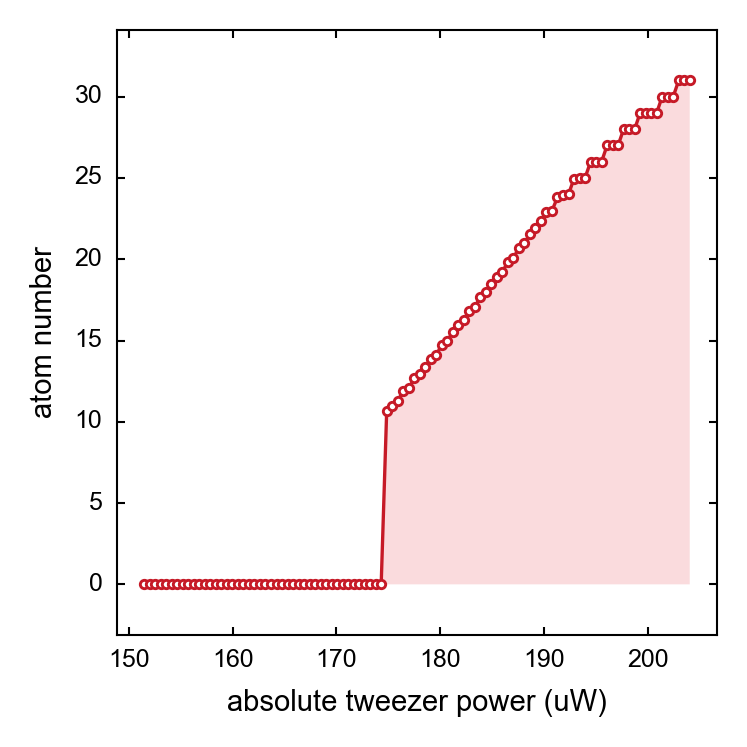

In [28]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("absolute tweezer power (uW)")
ax.set_ylabel("atom number")
ax.plot(powers*1e6, atom_number, marker=".")
ax.fill_between(powers*1e6, atom_number, fc=colors_alpha["red"], alpha=0.5)
#fig.savefig(FIGS_PATH / "twodtrap" / "1D Stufenplot.pdf")

-4.778250005541249e-30


Text(0, 0.5, 'E / h (kHz)')

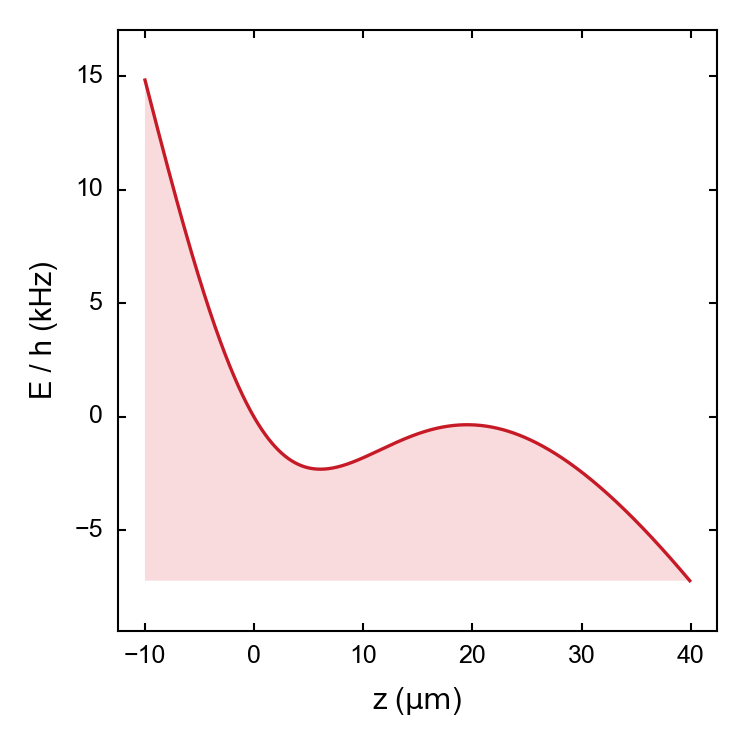

In [79]:
n_pot_steps = 1000
n_levels = 30

trap[trap.power_tweezer] = 200*si.uW
# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.z, (-0.5 * axial_width, 3 * axial_width), n_pot_steps, k=n_levels
)

pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.z)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

barrier = root_scalar(
    pot_diff_ax_numpy,
    x0=1.5 * float(trap.subs(axial_width)),
    fprime=pot_diff2_ax_numpy,
    xtol=1e-18,
    fprime2=pot_diff2_ax_numpy,
).root

# States that are below the potential barrier
bound_states = energies < potential(barrier)


# Density of states is larger on the left than on the right
# Likely that the state in question is a true bound state
true_bound_states = np.logical_and(
    bound_states,
    np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
    > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
)

width_np = float(trap.subs(axial_width))

z_np = np.linspace(-0.5 * width_np, 2 * width_np, num=1000)

ax: plt.Axes
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# ax.set_title("Axial")
abs_min = np.min(potential(z_np))
print(abs_min)
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    fc=colors_alpha["red"],
    alpha=0.5,
)
# ax2 = ax.twinx()

for i, bound in enumerate(true_bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)) & (z_np < barrier),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    #print(energy)
    ax.plot(z_np/si.um, state**2 *300, marker="None", c="k")

ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz, marker="None")
ax.set_xlabel(r"z ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")

In [76]:
true_bound_states

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

## Make 2D plots for power and gradient

In [10]:
n_spill_steps = 10

trap[trap.power_tweezer] = initial_power
trap[trap.waist_tweezer] = 2*si.um

powers = np.linspace(2.41,2.46,n_spill_steps)*si.mW
gradients = np.linspace(4.9,5.1,n_spill_steps)* si.G / si.cm
t_spill = 25 * si.ms
atom_number = np.zeros((n_spill_steps,n_spill_steps))
#array to store mean lifetime at specific power
mean_lifetime = np.zeros_like(atom_number)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 40
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers,position=0)):
    for k,gradient in enumerate(gradients):
        try:
            trap[trap.power_tweezer] = power
            trap[trap.grad_z] = gradient
            # Solve the hamiltonian numerically in axial direction
            energies, states, potential, coords = trap.nstationary_solution(
                trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
            )

            # Determine the potential and its derivatives
            pot_ax = trap.subs(trap.get_potential())
            pot_diff_ax = sp.diff(pot_ax, trap.z)
            pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
            pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
            pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
            pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
            pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

            barrier = root_scalar(
                pot_diff_ax_numpy,
                x0=1.5 * float(trap.subs(axial_width)),
                fprime=pot_diff2_ax_numpy,
                xtol=1e-28,
                fprime2=pot_diff2_ax_numpy,
            ).root
            minimum = root_scalar(
                pot_diff_ax_numpy,
                x0=0,
                fprime=pot_diff2_ax_numpy,
                xtol=1e-28,
                fprime2=pot_diff2_ax_numpy,
            ).root
            # States that are below the potential barrier
            bound_states = energies < potential(barrier)

            n_bound_states = np.sum(bound_states)
            n_levles = n_bound_states + 3  # add 3 more levels to be safe

            # Density of states is larger on the left than on the right
            # Likely that the state in question is a true bound state
            true_bound_states = np.logical_and(
                bound_states,
                np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
                > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
            )

            transmission_probability = np.full_like(energies, np.nan, dtype=float)
            for j, energy in enumerate(energies):
                if not true_bound_states[j]:
                    continue
                intersect_end = root_scalar(
                    lambda x: potential(x) - energy,
                    bracket=(barrier, 3 * float(trap.subs(axial_width))),
                ).root
                intersect_start = root_scalar(
                    lambda x: potential(x) - energy,
                    bracket=(minimum, barrier),
                ).root
                barrier_interval = np.logical_and(
                    coords[z] > intersect_start, coords[z] < intersect_end
                )
                s = quad(
                    lambda x: np.sqrt(
                        2
                        * float(trap.subs(trap.m))
                        * np.clip(potential(x) - energy, a_min=0, a_max=None)
                    )
                    / const.hbar,
                    intersect_start,
                    intersect_end,
                )
                transmission_probability[j] = sp.exp(-2 * s[0])
            tunneling_rate = (
                transmission_probability * np.abs(energies - potential(minimum)) / const.h
            )
            atom_number[i,k] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))
            mean_lifetime[i,k] = 1/np.mean(tunneling_rate[~np.isnan(tunneling_rate)])
        except:
            atom_number[i,k] = np.nan
            mean_lifetime[i,k] = np.nan

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\peter\AppData\Local\Temp\ipykernel_6676\3233720082.py:96: RuntimeWarning: divide by zero encountered in scalar divide
  mean_lifetime[i,k] = 1/np.mean(tunneling_rate[~np.isnan(tunneling_rate)])
100%|██████████| 10/10 [09:47<00:00, 58.78s/it]


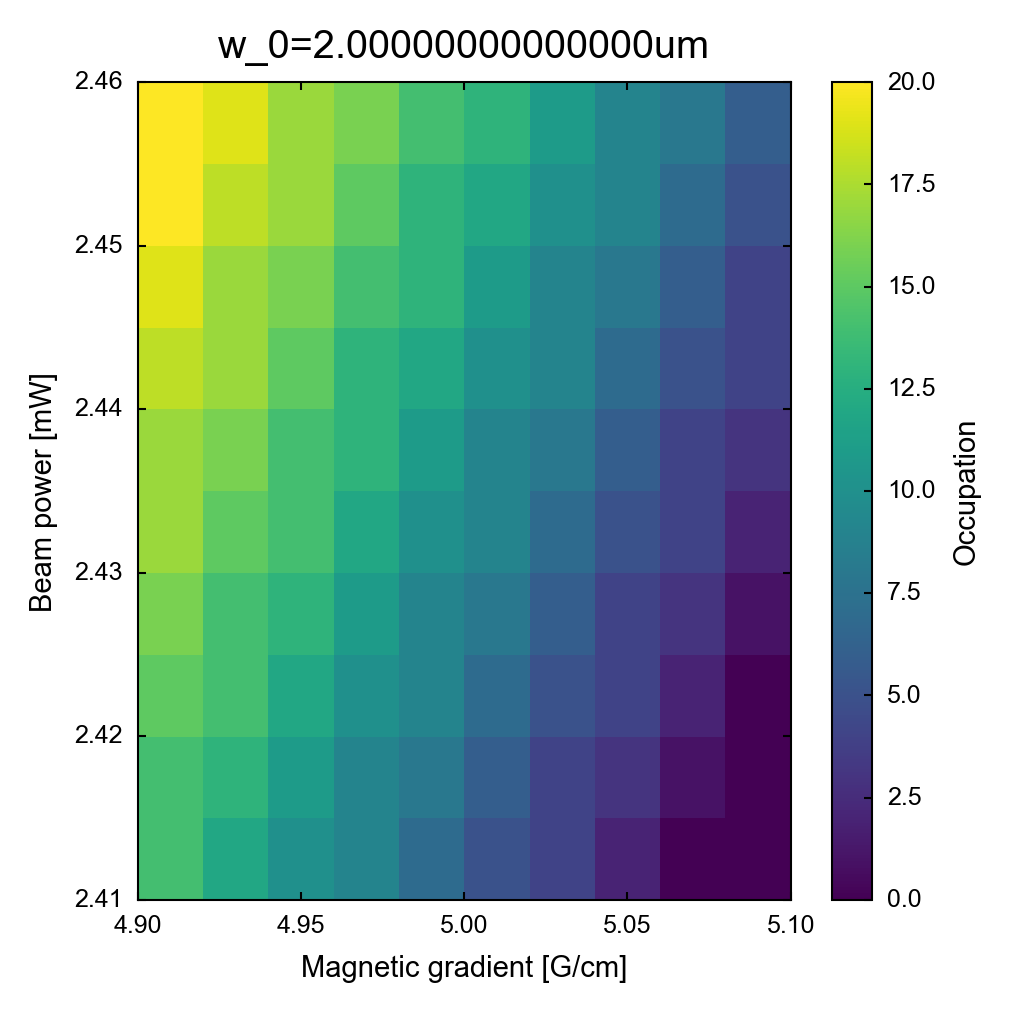

In [15]:
# Plot the main data
fig, ax1 = plt.subplots()
im = ax1.imshow(
    atom_number,
    extent=[
        np.min(gradients)/si.G*si.cm,
        np.max(gradients)/si.G*si.cm,
        np.min(powers)/si.mW,
        np.max(powers)/si.mW
    ],
    aspect="auto",
    origin="lower",
    cmap="viridis"
)

# Add colorbar
plt.colorbar(im, ax=ax1, label="Occupation")

# Primary axis labels
ax1.set_xlabel("Magnetic gradient [G/cm]")
ax1.set_ylabel("Beam power [mW]")
ax1.set_title(f"w_0={trap.subs(trap.waist_tweezer)*1e6}um")

plt.show()